<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
## Minjie Yang(my189)

## LIME for RESNET(model)

### Prepare model and libraries

In [1]:
!pip install lime torch torchvision tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=df777fb9a497b4f6e627f28c6c078352ce6996234d4e1f4b88094bb531505535
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [14]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained ResNet34 model
model = models.resnet34(pretrained=True).to(device)
model.eval()



Using device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Load class names of imagenet

In [15]:
# Load class names
class_names_path = "/content/imagenet_classes.txt"

# check whether it is good
with open(class_names_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]

print(class_names[:5])


['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


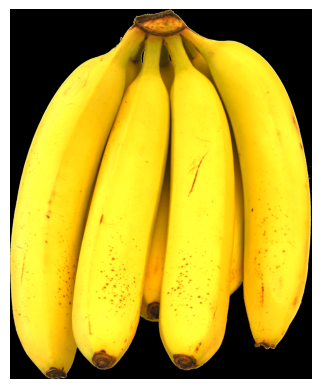

In [16]:
# sample of banana
img_path = "/content/Banana.png"
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()



In [17]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [18]:
img_t = get_input_tensors(img)
# Predict
with torch.no_grad():
    output = model(img_t)
_, predicted_class = output.max(1)
predicted_label = class_names[predicted_class.item()]
print(f"Predicted class: {predicted_class}")
print(f"Predicted label: {predicted_label}")

Predicted class: tensor([954])
Predicted label: banana


In [19]:

def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [20]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

954

In [21]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Initialize LIME explainer for images
explainer = lime_image.LimeImageExplainer()

# Explain the model's predictions for the image
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                      classifier_fn=batch_predict,
                      top_labels=5,
                      hide_color=0,
                      num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME top labels (indexes): [954, 950, 998, 939, 940]
LIME top labels (names): ['banana', 'orange', 'ear', 'zucchini', 'spaghetti squash']
Explaining predicted class: banana


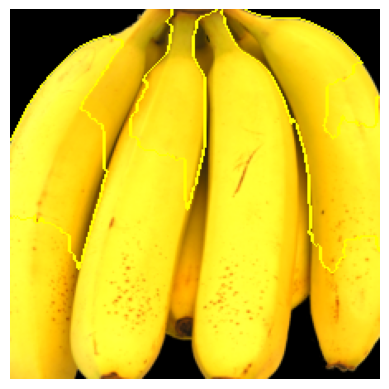

In [22]:
print(f"LIME top labels (indexes): {explanation.top_labels}")

lime_top_labels_names = [class_names[i] for i in explanation.top_labels]
print(f"LIME top labels (names): {lime_top_labels_names}")

# check predicted_class in LIME explainer
if predicted_class.item() in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(predicted_class.item(), positive_only=True, num_features=5, hide_rest=False)
    predicted_label_name = class_names[predicted_class.item()]
    print(f"Explaining predicted class: {predicted_label_name}")
else:
    # using top labels in LIME explainer
    top_label = explanation.top_labels[0]
    top_label_name = class_names[top_label]
    print(f"Predicted class {predicted_class.item()} not in LIME top labels, using top label: {top_label_name}")
    temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=True)

# show result
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()


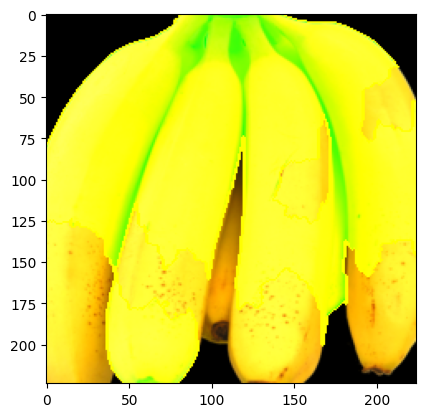

In [23]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)




1. **First Image (`positive_only=True`)**:
   This highlights only the features that positively contribute to predicting "banana." The yellow regions show the most influential parts of the image that help the model make the correct prediction.

2. **Second Image (`positive_only=False`)**:
   This shows both positive and negative features influencing the prediction. It highlights areas that either support or distract the model from predicting "banana," offering a broader view of the model's decision-making process.

### Conclusion:
The first result focuses on key features supporting the prediction, while the second gives a more complete view, showing both helpful and distracting areas the model considers.

## Discussion

**LIME was chosen** for its ability to explain any machine learning model without requiring access to internal workings, providing local, human-understandable explanations for individual predictions. It is simple to implement and supports various data types (images, text, tabular).

### Strengths:
- **Model-Agnostic**: Works with any model using prediction outputs.
- **Local Explanations**: Focuses on specific samples, making it ideal for varying predictions.
- **Intuitive Visualization**: Provides easy-to-understand visual explanations.
- **Ease of Use**: A well-supported library that integrates easily with various models.

### Limitations:
1. **Approximation, Not Exact**: LIME uses a simple surrogate model to approximate the behavior of the original model, which may not fully capture its complexity.
2. **Defining the Neighborhood**: It can be challenging to define an appropriate "neighborhood" around the instance being explained, which can lead to misleading interpretations.
3. **Instability of Explanations**: LIME’s explanations can vary across runs or experiments due to randomness in the perturbation process.
4. **Bias and Manipulation**: LIME can be fooled into hiding biases, and explanations can be manipulated by altering the perturbations or the surrogate model.
5. **Computational Cost**: Generating many perturbed samples and evaluating them with the black-box model is resource-intensive, particularly for large models.
6. **Limited Global Insight**: LIME provides only local explanations, which are useful for understanding individual predictions but do not offer insights into the model's global behavior.

### Improvements:
- **Stability**: Techniques such as smoothing or averaging over multiple LIME runs can reduce the variability and increase the consistency of explanations.
- **Integration with Global Techniques**: Combining LIME with global explanation methods like SHAP can offer a more comprehensive understanding of model behavior.
- **Better Perturbations**: More realistic perturbation methods, especially for text and images, could enhance the accuracy of the explanations. For example, semantic masking in images can yield better local approximations.

